# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import joblib

# Dataset

In [3]:
CTGData=pd.read_csv('CTG.csv')

In [4]:
CTGData3=CTGData.copy()
X=CTGData3.drop(labels=['CLASS','NSP'],axis=1)

y=CTGData3['CLASS'].values
y = LabelEncoder().fit_transform(y)

In [5]:
#stanardilization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [6]:
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)



In [6]:
gbm =lgbm_params=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',max_depth=4, num_leaves=300,
                                learning_rate=0.01,n_estimators=150)


In [7]:

score =cross_val_score(gbm, X_train, y_train, cv=5,scoring='neg_log_loss').mean()
print('cross validation loss at trainingset:',score) 

gbm.fit(X_train, y_train)
prob_gbm=gbm.predict_proba(X_test)
loss_gbm=log_loss(y_test,prob_gbm)
print('gbm at testset accuracy:',gbm.score(X_test,y_test)) 
print('loss at testset annually calculated :',loss_gbm)  

cross validation loss at trainingset: -0.5613216977286362
gbm at testset accuracy: 0.8661971830985915
loss at testset annually calculated : 0.5130267176377111


# Feature selection

## Bayes OPT hyperparameter searching

In [8]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt = BayesSearchCV(
     gbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt.fit(X_train, y_train)

stop=datetime.now()

execution_time_lgbm0=(stop-start)
print(execution_time_lgbm0)

0:05:55.407095


In [9]:
print('Best parameters found by Bayes search are:', BayerLgbmopt.best_params_)
print("val. score: %s" % BayerLgbmopt.best_score_)
print("test score: %s" % BayerLgbmopt.score(X_test, y_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.6635656726144148), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 300), ('num_leaves', 170), ('subsample', 0.8)])
val. score: -0.41698109115581783
test score: -0.33117232515362544


### Build the modle with the OPT hyperparameter

In [12]:
lgbm=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.6636,subsample= 0.8)

## Feature selection with the OPT model

0.6473027207806634 20
[1.9302045202091414, 1.9192654514749303, 1.5968717727797679, 1.5454677670177597, 1.4339954776104091, 1.3019408135688482, 1.245425756619373, 1.0998471683969893, 0.7875307013242443, 0.8047417427425112, 0.7829480901923367, 0.7052086718001307, 0.6970133291323772, 0.6582348790725618, 0.6693416478648562, 0.672443613512334, 0.6688205405404148, 0.6514468381945697, 0.660476251820816, 0.6473027207806634, 0.6473027207806634]


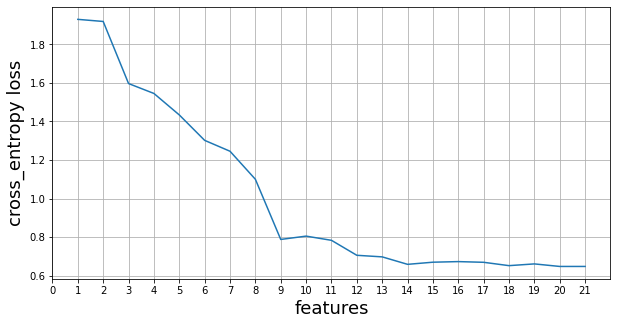

datetime.timedelta(seconds=738, microseconds=302835)

In [11]:
# 递归特征消除法和曲线图选取最优特征数量 
start=datetime.now()
score = []                                                            # 建立列表
for i in range(1,22, 1):
    X_wrapper=RFE(lgbm, n_features_to_select=i, step=1).fit_transform(X, y)      # 最优特征 
    once = cross_val_score(lgbm, X_wrapper, y, cv=5,scoring='neg_log_loss').mean()                      # 交叉验证
    score.append(once)                                                           # 交叉验证结果保存到列表
cross_entropy_loss=[j * -1 for j in score]

print(min(cross_entropy_loss), (cross_entropy_loss.index(min(cross_entropy_loss))*1)+1)                                 # 输出最优分类结果和对应的特征数量
print(cross_entropy_loss)
plt.figure(figsize=[10, 5])
plt.plot(range(1, 22, 1), cross_entropy_loss)
plt.xticks(range(0, 22))
plt.xlabel(u'features', fontsize=18)
plt.ylabel(u'cross_entropy loss', fontsize=18)
plt.grid()
plt.show()

stop=datetime.now()

execution_time_lgbm1=(stop-start)
execution_time_lgbm1

In [12]:
# 4.递归特征消除法
start=datetime.now()
selector = RFE(lgbm, n_features_to_select=20, step=1).fit(X, y)       # n_features_to_select表示筛选最终特征数量，step表示每次排除一个特征
selector.support_.sum()
print(selector.ranking_)                                             # 特征排除排序
print(selector.n_features_)                                          # 选择特征数量
X_wrapper_20 = selector.transform(X)                                   # 最优特征


stop=datetime.now()

execution_time_lgbm2=(stop-start)
execution_time_lgbm2

[1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
20


datetime.timedelta(seconds=4, microseconds=886164)

## Save the selected feature to csv file

In [13]:
index20=selector.get_support(indices=True)
index20

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [7]:
idx=[  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]
A=CTGData3.iloc[ :,idx]
A['label'] = y
A

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.000000,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,8
1,132,0.006380,0.000000,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,5
2,133,0.003322,0.000000,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,5
3,134,0.002561,0.000000,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,5
4,132,0.006515,0.000000,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140,0.000000,0.000000,0.007426,0.000000,0.0,79,0.2,25,7.2,...,137,177,4,0,153,150,152,2,0,4
2122,140,0.000775,0.000000,0.006971,0.000000,0.0,78,0.4,22,7.1,...,103,169,6,0,152,148,151,3,1,4
2123,140,0.000980,0.000000,0.006863,0.000000,0.0,79,0.4,20,6.1,...,103,170,5,0,153,148,152,4,1,4
2124,140,0.000679,0.000000,0.006110,0.000000,0.0,78,0.4,27,7.0,...,103,169,6,0,152,147,151,4,1,4


In [8]:
A.to_csv('CTGPattern selected 20 features.csv',index=False)

In [9]:
features20=pd.read_csv('CTGPattern selected 20 features.csv')
# ,index_col=0)
features20.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,8
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,5
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,5
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,5
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,1


In [10]:
X1=features20.drop(labels=['label'],axis=1)

y1=features20['label'].values

In [11]:
scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)

In [112]:
lgbm.fit(X1_train, y1_train)

LGBMClassifier(colsample_bytree=0.6636, learning_rate=0.01, max_depth=8,
               n_estimators=300, num_leaves=170, objective='multiclass',
               subsample=0.8)

In [122]:
y_pred_lgbm1=lgbm.predict((X1_test))
y_prob_lgbm1=lgbm.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.8826291079812206
F1 score with LGBM is:  0.8826291079812206
ROC_AUC score with LGBM is:  0.9877524107641038
Cross entropy loss score with LGBM is:  0.3595770189529092


## Explore the feature importance

In [113]:
lgbm.feature_importances_

array([ 7122, 10097,  3883,  8301,  7415,  1571,  8799,  5959,  5618,
        9132,  7412,  8095,  7160,  2755,   809,  5599,  7290,  5409,
        7734,   833])

In [114]:
featureName=features20.columns[:-1]

<BarContainer object of 20 artists>

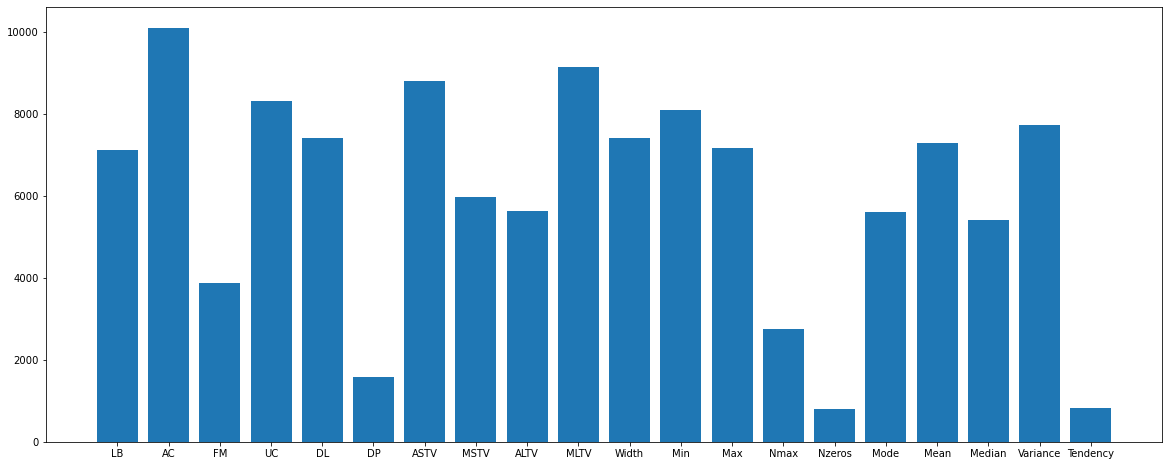

In [115]:
plt.figure(figsize=(20,8))
plt.bar(featureName,lgbm.feature_importances_)

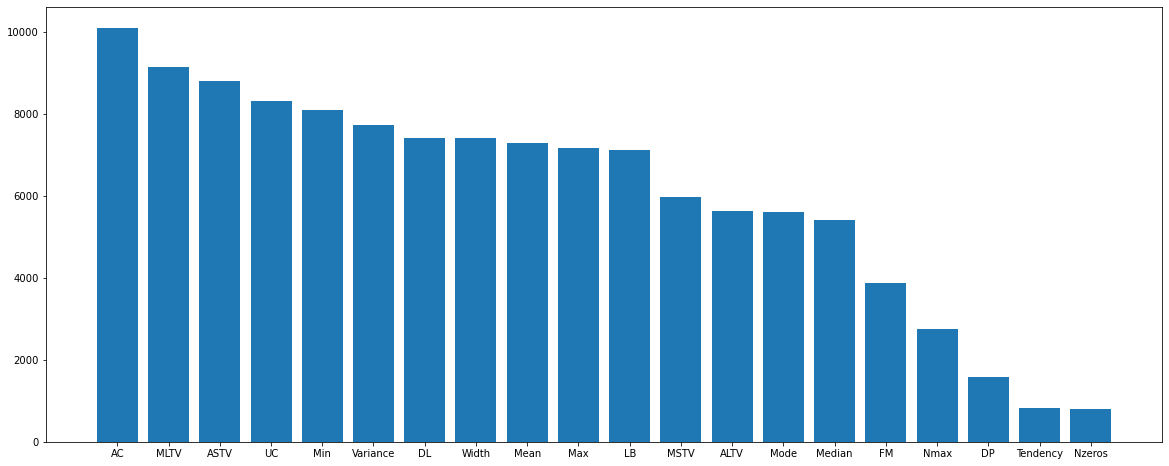

In [117]:
plt.figure(figsize=(20,8))
feature_important = pd.Series(lgbm.feature_importances_, index =featureName).sort_values(ascending=False)
plt.bar(feature_important.index, feature_important)
plt.show()

In [106]:
ClassData1=A[A['label']==1]
ClassData2=A[A['label']==2]
ClassData3=A[A['label']==3]
ClassData4=A[A['label']==4]
ClassData5=A[A['label']==5]
ClassData6=A[A['label']==6]
ClassData7=A[A['label']==7]
ClassData8=A[A['label']==8]
ClassData9=A[A['label']==9]
ClassData10=A[A['label']==10]

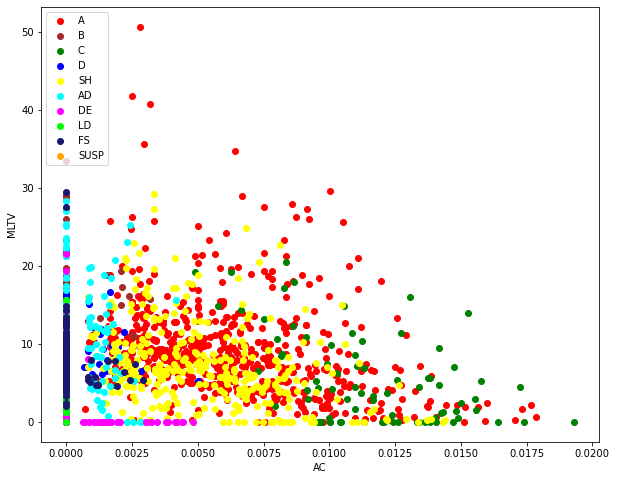

In [121]:
plt.figure(figsize=(10,8))
plt.scatter(ClassData1['AC'],ClassData1['MLTV'],c='red', label='A')
plt.scatter(ClassData2['AC'],ClassData2['MLTV'],c='brown', label='B')
plt.scatter(ClassData3['AC'],ClassData3['MLTV'],c='green', label='C')
plt.scatter(ClassData4['AC'],ClassData4['MLTV'],c='blue', label='D')
plt.scatter(ClassData5['AC'],ClassData5['MLTV'],c='yellow', label='SH')
plt.scatter(ClassData6['AC'],ClassData6['MLTV'],c='cyan', label='AD')
plt.scatter(ClassData7['AC'],ClassData7['MLTV'],c='magenta', label='DE')
plt.scatter(ClassData8['AC'],ClassData8['MLTV'],c='lime', label='LD')
plt.scatter(ClassData9['AC'],ClassData9['MLTV'],c='midnightblue', label='FS')
plt.scatter(ClassData10['AC'],ClassData10['MLTV'],c='orange', label='SUSP')
plt.xlabel('AC')
plt.ylabel('MLTV')
plt.legend(loc=2)
plt.show()

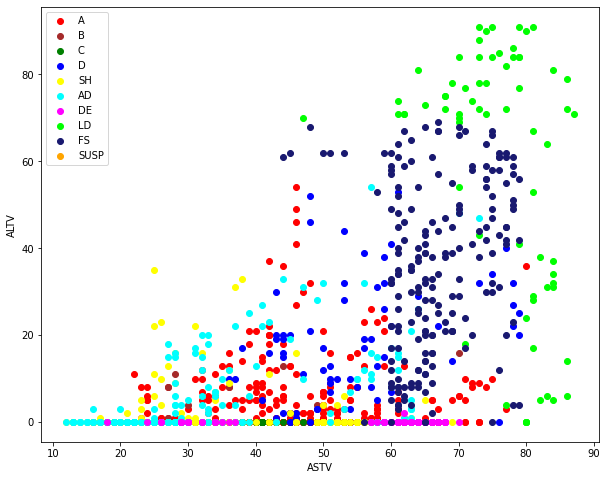

In [120]:
plt.figure(figsize=(10,8))
plt.scatter(ClassData1['ASTV'],ClassData1['ALTV'],c='red', label='A')
plt.scatter(ClassData2['ASTV'],ClassData2['ALTV'],c='brown', label='B')
plt.scatter(ClassData3['ASTV'],ClassData3['ALTV'],c='green', label='C')
plt.scatter(ClassData4['ASTV'],ClassData4['ALTV'],c='blue', label='D')
plt.scatter(ClassData5['ASTV'],ClassData5['ALTV'],c='yellow', label='SH')
plt.scatter(ClassData6['ASTV'],ClassData6['ALTV'],c='cyan', label='AD')
plt.scatter(ClassData7['ASTV'],ClassData7['ALTV'],c='magenta', label='DE')
plt.scatter(ClassData8['ASTV'],ClassData8['ALTV'],c='lime', label='LD')
plt.scatter(ClassData9['ASTV'],ClassData9['ALTV'],c='midnightblue', label='FS')
plt.scatter(ClassData10['ASTV'],ClassData10['ALTV'],c='orange', label='SUSP')
plt.xlabel('ASTV')
plt.ylabel('ALTV')
plt.legend(loc=2)
plt.show()

 # OPT for each model after RFE

## Light GBM

In [21]:
start=datetime.now()

# Bayers搜索，参数优化
BayerLgbmopt1 = BayesSearchCV(
     lgbm,
     {         
        'learning_rate': (0.005,0.01,0.001), 
        'n_estimators': (100,300), 
  
        'max_depth': (3,8), 
        'num_leaves':(8, 170),
         
        'subsample': (0.5,0.8), 
        'colsample_bytree': (0.5,0.8)
       
    } ,
     n_iter=50,
     cv=5
     ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)
BayerLgbmopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_lgbm3=(stop-start)
print(execution_time_lgbm3)

0:06:11.723811


In [22]:
print('Best parameters found by Bayes search are:', BayerLgbmopt1.best_params_)
print("val. score: %s" % BayerLgbmopt1.best_score_)
print("test score: %s" % BayerLgbmopt1.score(X1_test, y1_test))

Best parameters found by Bayes search are: OrderedDict([('colsample_bytree', 0.7100562355950126), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 300), ('num_leaves', 170), ('subsample', 0.5)])
val. score: -0.39853620080072305
test score: -0.3604962851482299


In [23]:
lgbm1=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.7101,subsample= 0.5)

In [24]:
start=datetime.now()
lgbm1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_lgbm40='%.4f'%(stop-start).total_seconds()
execution_time_lgbm40



'2.4188'

In [25]:

lgbm_ctgpatt=lgbm1.fit(X1_train,y1_train)

In [26]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.8873239436619719
F1 score with LGBM is:  0.8873239436619719
ROC_AUC score with LGBM is:  0.9880809383796739
Cross entropy loss score with LGBM is:  0.3604962851482299


In [27]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.8873
0.8873
0.9881
0.3605


In [28]:
start=datetime.now()
accuracy_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 20  feature:",accuracy_score_20)
print('F1 score 20  feature:',F1_score_20)
print('roc_auc 20  feature:',roc_auc_score_20)
print("cross entropy loss 20  feature:",neg_loss_score_20)


accuracy 20  feature: 0.8788235294117648
F1 score 20  feature: 0.8788235294117648
roc_auc 20  feature: 0.9887342339045496
cross entropy loss 20  feature: -0.39853620080072305


In [29]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

2.0854


In [30]:
# save the model
joblib.dump(lgbm_ctgpatt,'lgbm_ctgpatt.model')

['lgbm_ctgpatt.model']

In [31]:
rflgbm_CTGPATT=joblib.load('lgbm_ctgpatt.model')
   #应用模型进行预测
resultlgmb=rflgbm_CTGPATT.score(X1_test,y1_test)

In [32]:
resultlgmb

0.8873239436619719

## SVM & Bayes Optimization

In [82]:
#using the original dataset
svc0 = SVC(random_state=42
           ,C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
accuracies = cross_val_score(svc0,X_train,y_train,cv=5)
svc0.fit(X_train,y_train)
svc0.predict(X_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc0.score(X_test,y_test))

Train Score: 0.8264705882352941
Test Score: 0.8685446009389671


In [33]:
#using the feature selection dataset
svc = SVC(random_state=42
           ,C= 8.5385
           ,kernel='rbf'
           ,degree= 7
          ,gamma="scale"
          , probability=True)
accuracies = cross_val_score(svc,X1_train,y1_train,cv=5)
svc.fit(X1_train,y1_train)
svc.predict(X1_test)
print("Train Score:",np.mean(accuracies))
print("Test Score:",svc.score(X1_test,y1_test))

Train Score: 0.8158823529411766
Test Score: 0.8661971830985915


In [35]:
pred=svc.predict(X1_test)
prob=svc.predict_proba(X1_test)
print("Test loss Score:",log_loss(y1_test,prob))

Test loss Score: 0.3814698783679155


In [76]:
start=datetime.now()                
# log-uniform: understand as search over p = exp(x) by varying x
BayerSvmopt = BayesSearchCV(
    SVC(probability=True, random_state=42
          ,C=8.5385
#           ,degree= 7
          ,gamma= 'scale'
           ,kernel='rbf'
        
#            ,random_state=42
# #           ,gamma="scale"
#           , probability=True
    ),
    {
        
#        'kernel': ['linear', 'poly', 'rbf'],
#         'C':(1, 10),     
#         'gamma': (0.01, 1),
          'degree':(1,10)

    },
 
    n_iter=50,
    cv=5
    ,scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

BayerSvmopt.fit(X1_train, y1_train)
stop=datetime.now()

execution_time_svm1=(stop-start)
execution_time_svm1


datetime.timedelta(seconds=105, microseconds=986021)

In [77]:
print("best params: %s" % str(BayerSvmopt.best_params_))


print("val. score: %s" % BayerSvmopt.best_score_)
print("test score: %s" % BayerSvmopt.score(X1_test, y1_test))

best params: OrderedDict([('degree', 5)])
val. score: -0.45747587619178437
test score: -0.444199366381375


In [80]:
svc1=SVC(probability=True, random_state=42
           ,C=8.5385
           ,degree= 5
           ,gamma= 'scale'
           ,kernel='rbf')

In [81]:
svc1.fit(X1_train,y1_train)
svc1.score(X1_test,y1_test)

0.8309859154929577

In [40]:

start=datetime.now()
svc_ctgpatt=svc1.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()

print(execution_time_svc)

0.4139


In [41]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.815294117647059
F1 score 20  feature: 0.815294117647059
roc_auc 20  feature: 0.9843844249158666
cross entropy loss 20  feature: -0.47173239131086164


In [42]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.3189


In [43]:
y_pred_svc1=svc1.predict(X1_test)
y_prob_svc1=svc1.predict_proba(X1_test)

In [44]:

svc_accuracy='%.4f'%accuracy_score(y1_test, y_pred_svc1)
svc_f1='%.4f'%f1_score(y1_test, y_pred_svc1,average='micro')
svc_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_svc1,multi_class='ovr',labels=np.unique(y1_test))
svc_loss='%.4f'%log_loss(y1_test,y_prob_svc1)
print(svc_accuracy)
print(svc_f1)
print(svc_roc_auc)
print(svc_loss)

0.8474
0.8474
0.9860
0.4040


In [45]:
  #保存模型
joblib.dump(svc_ctgpatt,'svc_ctgpatt.model')

['svc_ctgpatt.model']

In [46]:
#加载模型
RFsvc=joblib.load('svc_ctgpatt.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [47]:
resultsvc

0.8474178403755869

## Random Forest

In [48]:
rf = RFC(random_state=42)


Bayesrfopt = BayesSearchCV(
   rf,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt.fit(X_train, y_train)
print('Best parameters found by grid search are:', Bayesrfopt.best_params_)

Best parameters found by grid search are: OrderedDict([('criterion', 'entropy'), ('max_depth', 12), ('max_features', 'sqrt'), ('n_estimators', 150)])


In [49]:
print("val. score: %s" % Bayesrfopt.best_score_)
print("test score: %s" % Bayesrfopt.score(X_test, y_test))

val. score: -0.4311345452246913
test score: -0.39806612773492256


In [50]:
rf1 = RFC(random_state=42, max_features='sqrt', n_estimators= 150,
                                     max_depth=12, 
                                     criterion='entropy')

In [51]:
start=datetime.now()
rf1.fit(X_train,y_train)
stop=datetime.now()
execution_time_rf=(stop-start)
execution_time_rf
training_time_rf0=execution_time_rf.total_seconds()
training_time_rf0='%.4f'%training_time_rf0
print(training_time_rf0)

0.6584


In [52]:
start=datetime.now()
Bayesrfopt1 = BayesSearchCV(
   rf1,
    {   
    'n_estimators': [50,100,150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,None],
    'criterion' :['gini', 'entropy']
    },
    n_iter=50,
    cv=5,
    scoring="neg_log_loss"
    ,random_state=42
    ,n_points=2
)

Bayesrfopt1.fit(X1_train, y1_train)

stop=datetime.now()
execution_time_rf0=(stop-start)
print(execution_time_rf0)
print('Best parameters found by grid search are:', Bayesrfopt1.best_params_)

0:02:03.202522
Best parameters found by grid search are: OrderedDict([('criterion', 'gini'), ('max_depth', 13), ('max_features', 'auto'), ('n_estimators', 150)])


In [53]:

print("val. score: %s" % Bayesrfopt1.best_score_)
print("test score: %s" % Bayesrfopt1.score(X1_test, y1_test))

val. score: -0.4427296871907811
test score: -0.3962507171450697


In [54]:
rf2= RFC(random_state=42, max_features='auto', n_estimators= 150,
                                     max_depth=13, 
                                     criterion='gini')


In [55]:
start=datetime.now()
accuracy_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 10  feature:",accuracy_score_10_rf)
print('F1 score 10  feature:',F1_score_10_rf)
print('roc_auc 10  feature:',roc_auc_score_10_rf)
print("cross entropy loss 10  feature:",neg_loss_score_10_rf)

accuracy 10  feature: 0.8623529411764708
F1 score 10  feature: 0.8623529411764708
roc_auc 10  feature: 0.9886995224003403
cross entropy loss 10  feature: -0.4427296871907811


In [56]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.4234


In [57]:
rf_ctgpatt=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with LGBM is:  0.8732394366197183
F1 score with LGBM is:  0.8732394366197183
ROC_AUC score with LGBM is:  0.9896338701453444
Cross entropy loss score with LGBM is:  0.3962507171450697
0.8732
0.8732
0.9896
0.3963


In [58]:
# save the model
joblib.dump(rf_ctgpatt,'rf_ctgpatt.model')

['rf_ctgpatt.model']

In [59]:
   #加载模型
RFrf=joblib.load('rf_ctgpatt.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [60]:
rfresult

0.8732394366197183